In [1]:
!pip install iterative-stratification


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import numpy as np
import pandas as pd
import re

from collections import Counter

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

In [3]:
data_path = "arxiv-metadata-oai-snapshot.json"
data = []

with open(data_path, "r", encoding="utf-8") as f:
    for line in tqdm(f):
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(data)

4924it [00:00, 49229.13it/s]

2908095it [02:58, 16257.41it/s]


In [4]:
def multilabel_sample(df, n):
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(df["categories"].str.split())

    msss = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=n,
        test_size=len(df) - n,
        random_state=42
    )

    for idx, _ in msss.split(df, Y):
        return df.iloc[idx]


s1 = multilabel_sample(df, 200000)
s2 = multilabel_sample(df, 200000)

In [5]:
def category_distribution(df):
    c = Counter()
    for cats in df["categories"].str.split():
        c.update(cats)

    total = sum(c.values())

    return {k: v / total for k, v in c.items()}


dist_full = category_distribution(df)
dist_s1 = category_distribution(s1)
dist_s2 = category_distribution(s2)

diff = {
    k: abs(dist_s1.get(k, 0) - dist_s2.get(k, 0))
    for k in dist_full
}

max(diff.values()), sum(diff.values()) / len(diff)

(0.0, 0.0)

In [6]:
df["category_list"] = df["categories"].str.split()

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["category_list"])

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    train_size=200000,
    test_size=len(df) - 200000,
    random_state=42
)

for train_idx, _ in msss.split(df, Y):
    df_sample = df.iloc[train_idx].copy()

In [7]:
df_sample.to_parquet("arxiv_sample_200k.parquet")

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
sns.set_style("whitegrid")

In [9]:
df_sample = pd.read_parquet("arxiv_sample_200k.parquet")

df = df_sample.copy()

print("Shape:", df.shape)
df.head(2)

Shape: (199749, 15)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,category_list
8,0704.0009,Paul Harvey,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...","The Spitzer c2d Survey of Large, Nearby, Inste...",None,"Astrophys.J.663:1149-1173,2007",10.1086/518646,None,astro-ph,None,We discuss the results from the combined IRA...,"[{'created': 'Mon, 2 Apr 2007 19:41:34 GMT', '...",2010-03-18,"[[Harvey, Paul, ], [Merin, Bruno, ], [Huard, T...",[astro-ph]
16,0704.0017,Nceba Mhlahlo,"Nceba Mhlahlo, David H. Buckley, Vikram S. Dhi...",Spectroscopic Observations of the Intermediate...,"10 pages, 11 figures (figures 3, 4, 7 and 8 at...","Mon.Not.Roy.Astron.Soc.378:211-220,2007",10.1111/j.1365-2966.2007.11762.x,None,astro-ph,None,Results from spectroscopic observations of t...,"[{'created': 'Sat, 31 Mar 2007 07:38:48 GMT', ...",2009-06-23,"[[Mhlahlo, Nceba, ], [Buckley, David H., ], [D...",[astro-ph]


In [10]:
df["id"].is_unique

True

In [11]:
df.isna().mean().sort_values(ascending=False).head(10)

report-no      0.935018
journal-ref    0.683643
doi            0.560819
comments       0.270374
license        0.154779
submitter      0.005447
id             0.000000
title          0.000000
authors        0.000000
categories     0.000000
dtype: float64

In [12]:
df["category_list"] = df["categories"].str.split()
df["author_list"] = df["authors"].str.split(", ")

In [13]:
df["year"] = df["versions"].apply(
    lambda v: pd.to_datetime(v[0]["created"]).year
)

In [14]:
df["year"].describe()

count    199749.000000
mean       2016.151060
std           7.732047
min        1989.000000
25%        2012.000000
50%        2018.000000
75%        2022.000000
max        2025.000000
Name: year, dtype: float64

In [15]:
df["abstract_word_count"] = (
    df["abstract"]
    .fillna("")
    .str.split()
    .str.len()
)

df["abstract_word_count"].describe()

count    199749.000000
mean        144.250274
std          62.953060
min           3.000000
25%          96.000000
50%         141.000000
75%         188.000000
max         584.000000
Name: abstract_word_count, dtype: float64

In [16]:
word_count_bins = [1, 50, 100, 150, 200, 250, 300, 350, 400]

df["abstract_word_count_group"] = pd.cut(
    df["abstract_word_count"],
    bins=word_count_bins,
    right=False
)

abstract_word_counts = (
    df["abstract_word_count_group"]
    .value_counts()
    .sort_index()
)

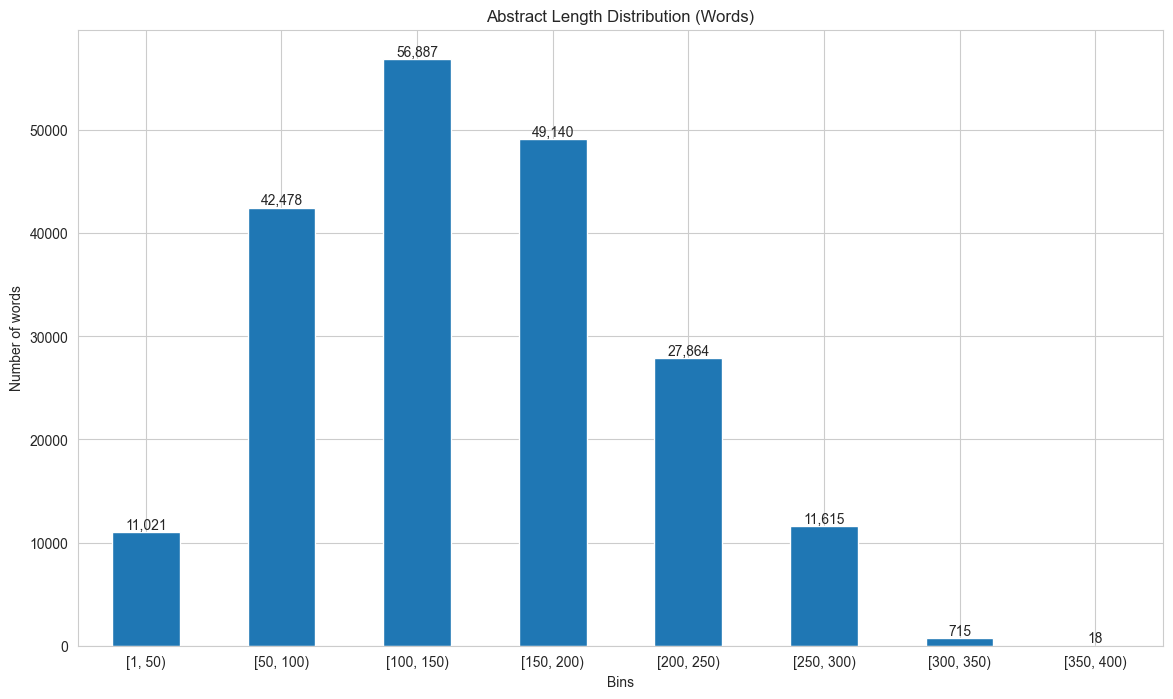

In [17]:
plt.figure(figsize=(14,8))
ax = abstract_word_counts.plot(kind="bar")

plt.title("Abstract Length Distribution (Words)")
plt.xlabel("Bins")
plt.ylabel("Number of words")

plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.show()

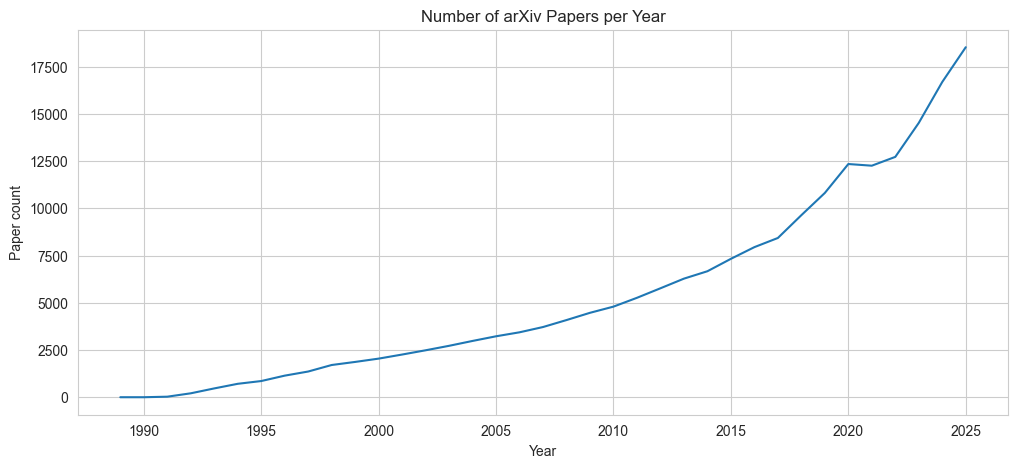

In [18]:
papers_per_year = df.groupby("year").size()

plt.figure(figsize=(12,5))
papers_per_year.plot()
plt.title("Number of arXiv Papers per Year")
plt.xlabel("Year")
plt.ylabel("Paper count")
plt.show()

In [19]:
LLM_KEYWORDS = [
    "large language model",
    "large language models",
    "llm",
    "llms",
    "foundation model",
    "foundation models",

    "transformer",
    "transformers",
    "bert",
    "roberta",
    "t5",
    "gpt",
    "gpt-2",
    "gpt-3",
    "gpt-4",
    "chatgpt",
    "llama",
    "palm",
    "falcon",
    "mistral",

    "pretrained language model",
    "pre-trained language model",
    "self-supervised learning",
    "instruction tuning",
    "prompt tuning",
    "prompt engineering",
    "in-context learning",

    "text generation",
    "language generation",
    "natural language generation",
    "zero-shot",
    "few-shot",

    "attention mechanism",
    "self-attention"
]


In [20]:
pattern = re.compile(
    r"\b(" + "|".join(map(re.escape, LLM_KEYWORDS)) + r")\b"
)

df["text_for_llm"] = (
    df["title"].fillna("") + " " + df["abstract"].fillna("")
).str.lower()

df["has_llm"] = df["text_for_llm"].apply(
    lambda x: bool(pattern.search(x))
)

In [21]:
llm_df = df[
    (df["year"] >= 2020) &
    (df["has_llm"])
]

llm_by_year = llm_df.groupby("year").size()

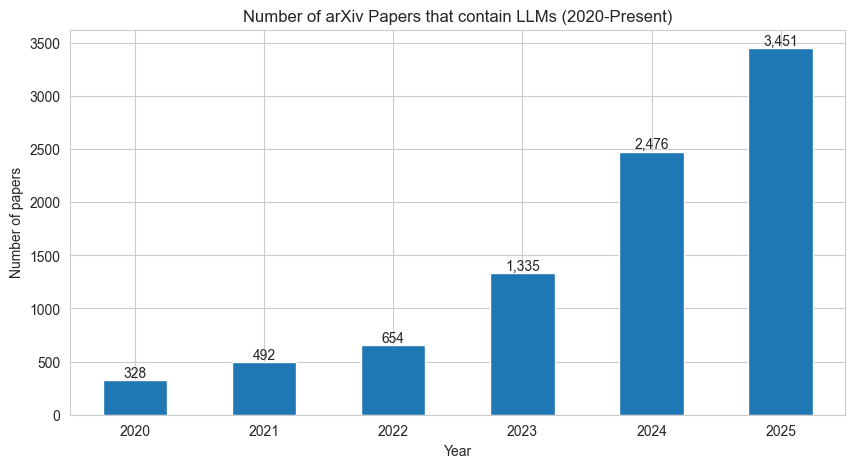

In [22]:
plt.figure(figsize=(10,5))
ax = llm_by_year.plot(kind="bar")

plt.title("Number of arXiv Papers that contain LLMs (2020-Present)")
plt.xlabel("Year")
plt.ylabel("Number of papers")

plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.show()


In [23]:
CATEGORY_FULL_NAME = {
    "cs.LG": "Computer Science - Machine Learning",
    "cs.AI": "Computer Science - Artificial Intelligence",
    "cs.CV": "Computer Science - Computer Vision",
    "cs.CL": "Computer Science - Computation and Language",
    "cs.NE": "Computer Science - Neural and Evolutionary Computing",
    "cs.RO": "Computer Science - Robotics",
    "cs.IT": "Computer Science - Information Theory",

    "math.PR": "Mathematics - Probability",
    "math.ST": "Mathematics - Statistics",
    "math.AP": "Mathematics - Analysis of PDEs",
    "math.OC": "Mathematics - Optimization and Control",
    "math.CO": "Mathematics - Combinatorics",
    "math.MP": "Mathematics - Mathematical Physics",

    "hep-ph": "High Energy Physics - Phenomenology",
    "hep-th": "High Energy Physics - Theory",
    "astro-ph": "Astrophysics",
    "astro-ph.CO": "Astrophysics - Cosmology",
    "astro-ph.GA": "Astrophysics - Galaxy Astrophysics",
    "quant-ph": "Quantum Physics",
    "gr-qc": "General Relativity and Quantum Cosmology",
    "cond-mat.mtrl-sci": "Condensed Matter - Materials Science",
    "cond-mat.mes-hall": "Condensed Matter - Mesoscale and Nanoscale Physics",
    "cond-mat.stat-mech": "Condensed Matter - Statistical Mechanics",
    "cond-mat.str-el": "Condensed Matter - Strongly Correlated Electrons",
    "stat.ML": "Statistics - Machine Learning"
}

In [24]:
df["full_name"] = df["categories"].map(
    CATEGORY_FULL_NAME
).fillna(df["categories"])

In [25]:
cat_counter = Counter()

for cats in df["category_list"]:
    cat_counter.update(cats)

cat_df = pd.DataFrame(
    cat_counter.most_common(20),
    columns=["category", "count"]
)

cat_df["category"] = cat_df["category"].map(
    CATEGORY_FULL_NAME
).fillna(cat_df["category"])

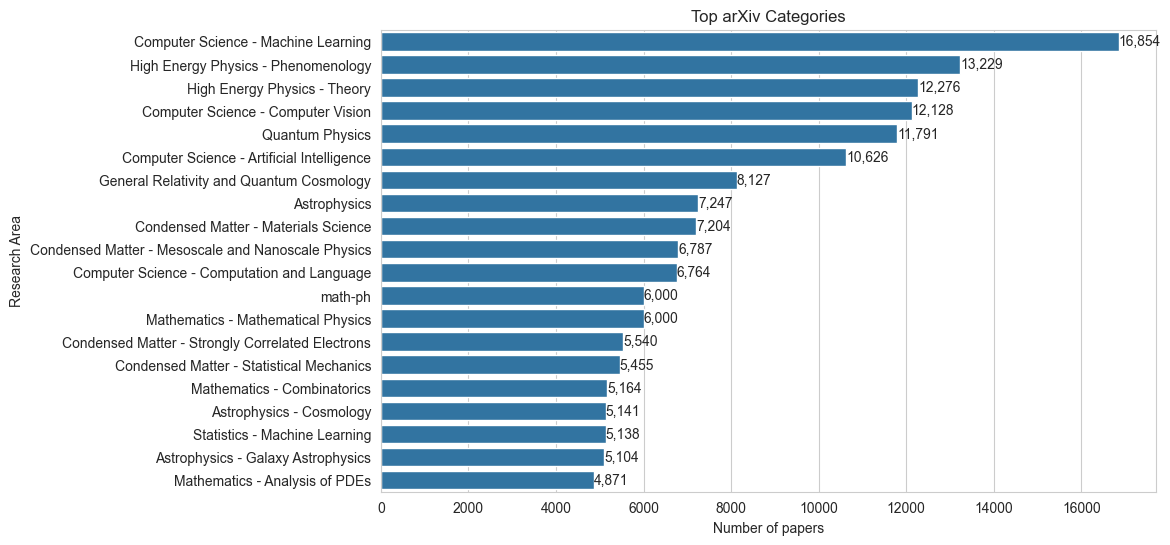

In [26]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=cat_df,
    x="count",
    y="category"
)

plt.title("Top arXiv Categories")
plt.xlabel("Number of papers")
plt.ylabel("Research Area")

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_width()):,}",
        (p.get_width(), p.get_y() + p.get_height() / 2),
        va="center",
        fontsize=10
    )

plt.show()


In [27]:
df["top_domain"] = df["categories"].apply(
    lambda x: x.split()[0].split(".")[0]
)

df_cs_math = df[df["top_domain"].isin(["cs", "math"])].copy()

In [28]:
TOP_DOMAIN_FULL_NAME = {
    "cs": "Computer Science",
    "math": "Mathematics"
}

In [29]:
df_cs_math["top_domain"] = df_cs_math["top_domain"].map(
    TOP_DOMAIN_FULL_NAME
).fillna(df["top_domain"])

In [30]:
domain_year = (
    df_cs_math
    .groupby(["year", "top_domain"])
    .size()
    .unstack(fill_value=0)
)

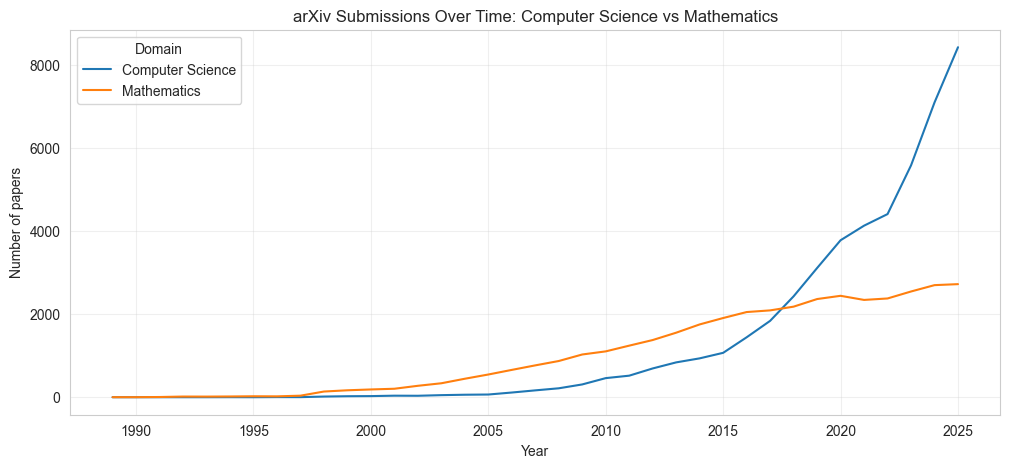

In [31]:
ax = domain_year.plot(figsize=(12,5))

plt.title("arXiv Submissions Over Time: Computer Science vs Mathematics")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.legend(title="Domain")

plt.grid(alpha=0.3)
plt.show()

In [32]:
year_cat = []

for _, row in df.iterrows():
    for cat in row["category_list"]:
        year_cat.append((row["year"], cat))

year_cat_df = pd.DataFrame(year_cat, columns=["year", "category"])

year_cat_df["full_name"] = (
    year_cat_df["category"]
    .map(CATEGORY_FULL_NAME)
    .fillna(year_cat_df["category"])
)

In [33]:
top_categories = cat_df["category"].head(8)

trend_df = (
    year_cat_df[year_cat_df["full_name"].isin(top_categories)]
    .groupby(["year", "full_name"])
    .size()
    .unstack(fill_value=0)
)

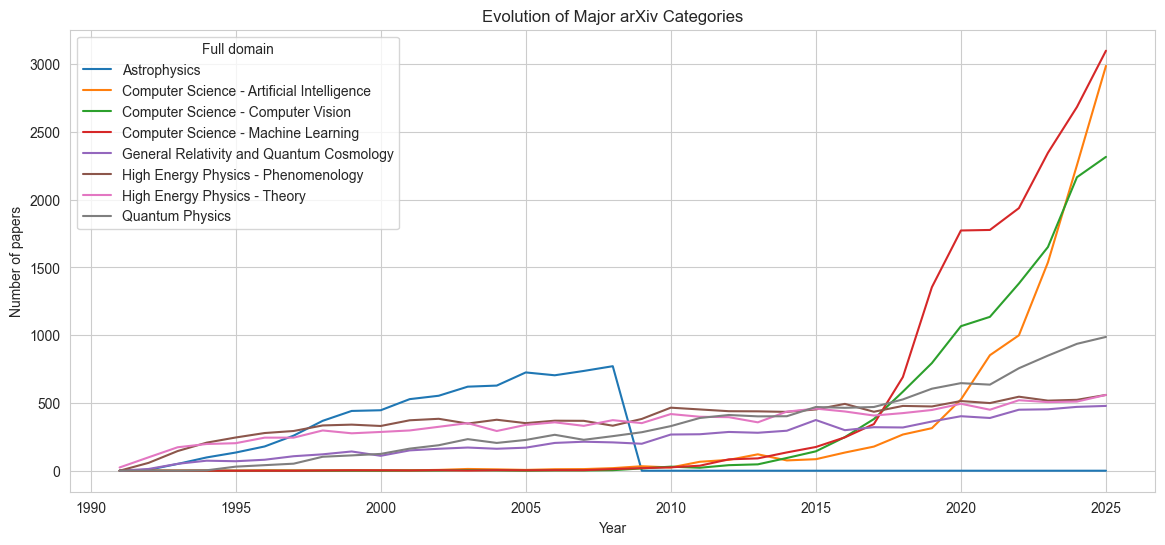

In [34]:
trend_df.plot(figsize=(14,6))
plt.title("Evolution of Major arXiv Categories")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.legend(title="Full domain")
plt.show()

In [35]:
COUNTRY_KEYWORDS = {
    "usa", "united states", "uk", "united kingdom", "china", "france",
    "germany", "italy", "spain", "canada", "japan", "korea", "australia",
    "india", "switzerland", "netherlands", "sweden", "norway", "denmark",
    "brazil", "russia"
}

AFFILIATION_KEYWORDS = {
    "university", "institute", "laboratory", "lab", "college",
    "school", "department", "center", "centre", "academy", "et al"
}

In [36]:
def clean_authors(author_str):
    if not isinstance(author_str, str):
        return []

    author_str = re.sub(r"\(.*?\)", "", author_str)

    parts = [p.strip() for p in author_str.split(",")]

    clean = []
    for p in parts:
        p_low = p.lower()

        if any(k in p_low for k in COUNTRY_KEYWORDS):
            continue
        if any(k in p_low for k in AFFILIATION_KEYWORDS):
            continue

        if len(p.split()) >= 2:
            clean.append(p)

    return clean


In [37]:
author_counter = Counter()

for author_str in df["authors"]:
    clean_list = clean_authors(author_str)
    author_counter.update(clean_list)

author_df = pd.DataFrame(
    author_counter.most_common(20),
    columns=["author", "paper_count"]
)

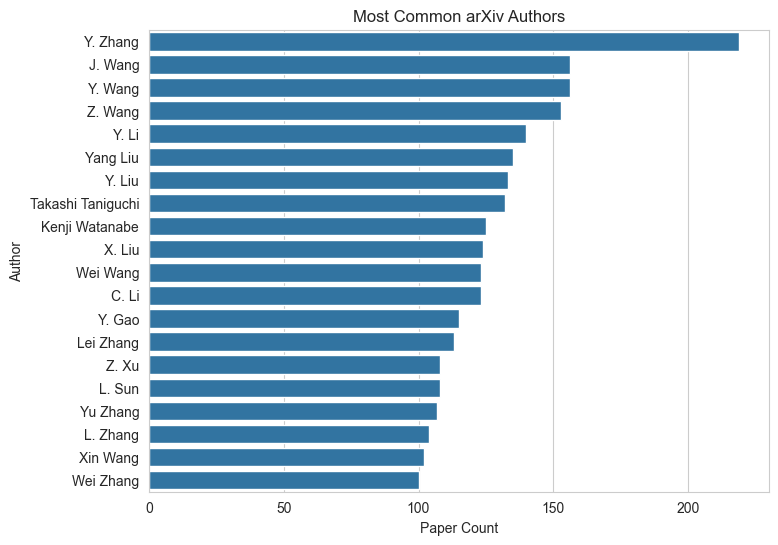

In [38]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=author_df,
    x="paper_count",
    y="author"
)
plt.title("Most Common arXiv Authors")
plt.xlabel("Paper Count")
plt.ylabel("Author")
plt.show()

In [39]:
df["n_authors"] = df["author_list"].apply(len)

df["n_authors"].describe()

count    199749.000000
mean          4.421324
std          24.613828
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max        1953.000000
Name: n_authors, dtype: float64

In [40]:
author_bins = [1, 2, 3, 5, 10, 20, 50, 100]
df["author_group"] = pd.cut(
    df["n_authors"],
    bins=author_bins,
    right=False
)

author_counts = (
    df["author_group"]
    .value_counts()
    .sort_index()
)

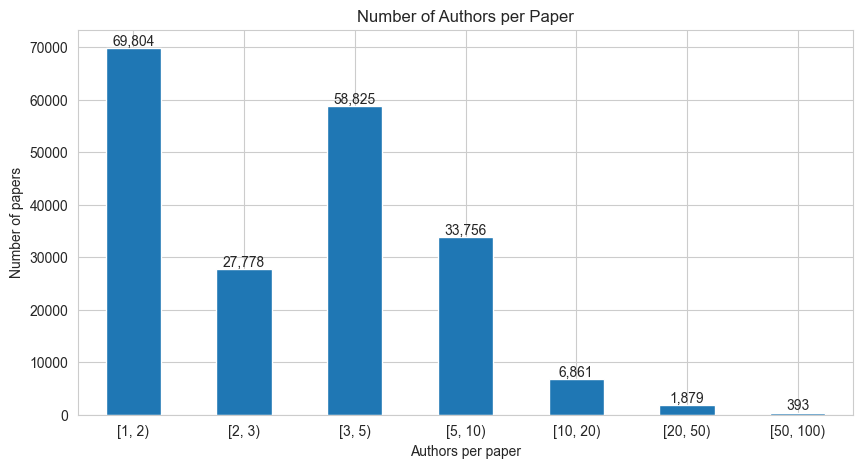

In [41]:
plt.figure(figsize=(10,5))
ax = author_counts.plot(kind="bar")

plt.title("Number of Authors per Paper")
plt.xlabel("Authors per paper")
plt.ylabel("Number of papers")

plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.show()

In [42]:
vectorizer = CountVectorizer(
    stop_words="english",
    max_features=20
)

X = vectorizer.fit_transform(df["abstract"].dropna().sample(50_000))

In [43]:
term_freq = pd.DataFrame({
    "term": vectorizer.get_feature_names_out(),
    "count": X.sum(axis=0).A1
}).sort_values("count", ascending=False)

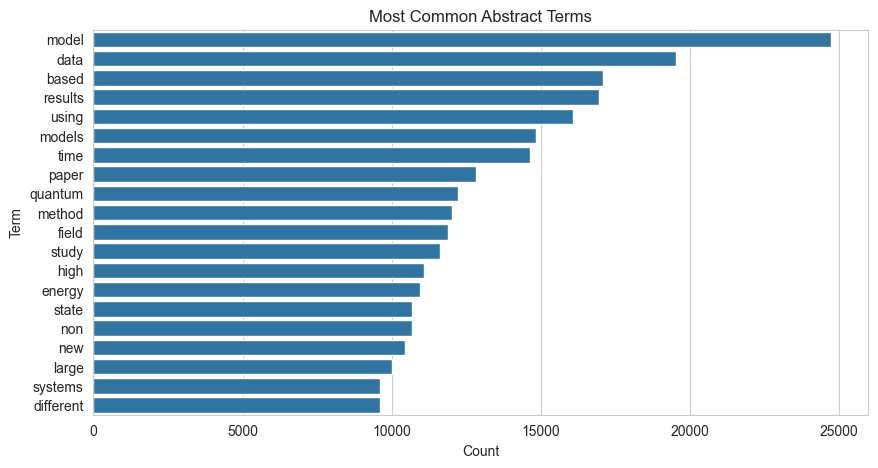

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(data=term_freq, x="count", y="term")
plt.title("Most Common Abstract Terms")
plt.xlabel("Count")
plt.ylabel("Term")
plt.show()

In [45]:
llm_vectorizer = CountVectorizer(
    vocabulary=LLM_KEYWORDS,
    lowercase=True,
    ngram_range=(1, 3)
)

llm_X = llm_vectorizer.fit_transform(df["abstract"].dropna().sample(50_000))

In [46]:
llm_term_freq = pd.DataFrame({
    "term": llm_vectorizer.get_feature_names_out(),
    "count": llm_X.sum(axis=0).A1
}).sort_values("count", ascending=False)

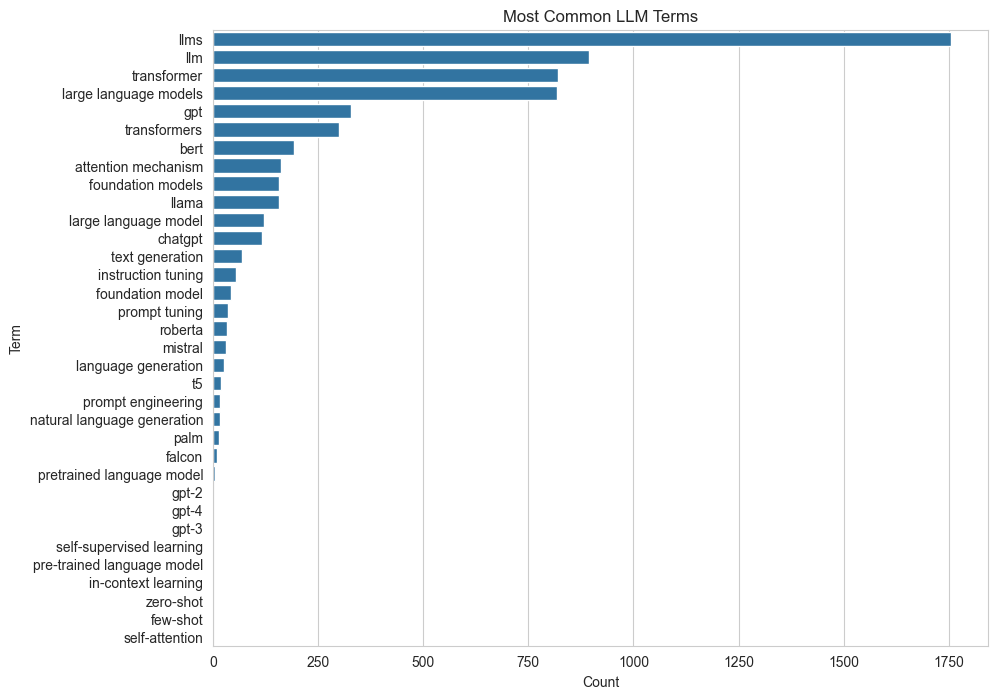

In [47]:
plt.figure(figsize=(10,8))
sns.barplot(data=llm_term_freq, x="count", y="term")
plt.title("Most Common LLM Terms")
plt.xlabel("Count")
plt.ylabel("Term")
plt.show()